In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import sys, itertools

In [3]:
# 读取Excel文件
df = pd.read_excel('A1.xlsx', usecols=['销量（箱）', '金额（元）'])
# 去掉无数值的行
df.dropna(inplace=True)
# 将数据转换为NumPy数组
data_array = df.values

In [4]:
n = data_array.shape[0]
data = data_array[:, 0]  # 选择销量数据
index = pd.date_range(start='2011-01', periods=n, freq='M')
series = pd.Series(data, index=index)

In [5]:
series = series.loc['2014-01':]

In [6]:
# 创建 MinMaxScaler 的实例
scaler = MinMaxScaler()
# 使用 fit_transform 方法来拟合数据并转换它
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

ADF Statistic: -6.571270009202938
p-value: 7.925054625765e-09


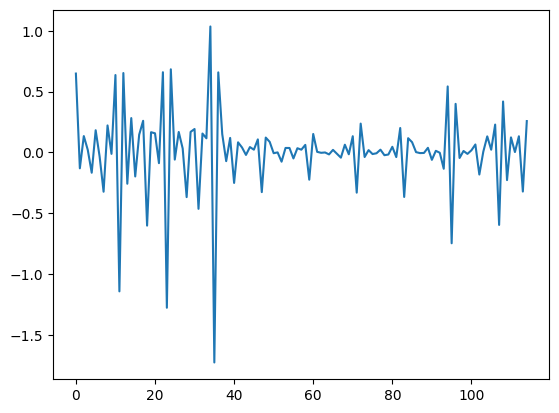

In [7]:
def test_stationarity(timeseries):
	dftest = adfuller(timeseries, autolag='AIC')
	print(f'ADF Statistic: {dftest[0]}')
	print(f'p-value: {dftest[1]}')
	plt.plot(timeseries)
	plt.show()
test_stationarity(np.diff(data, 2))

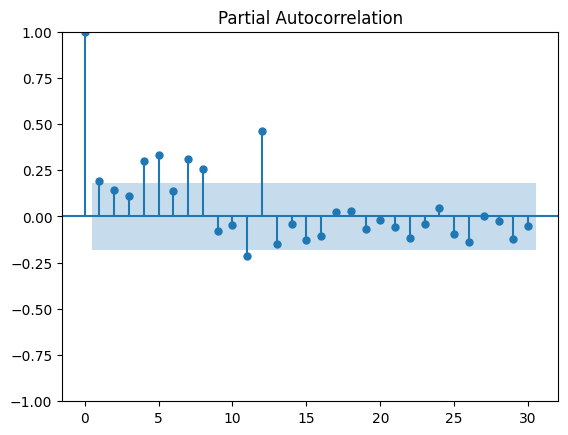

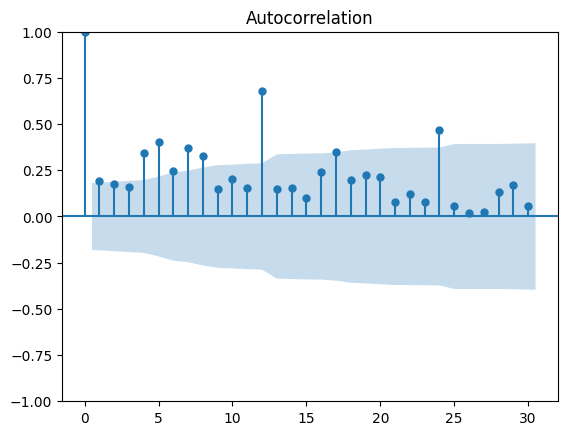

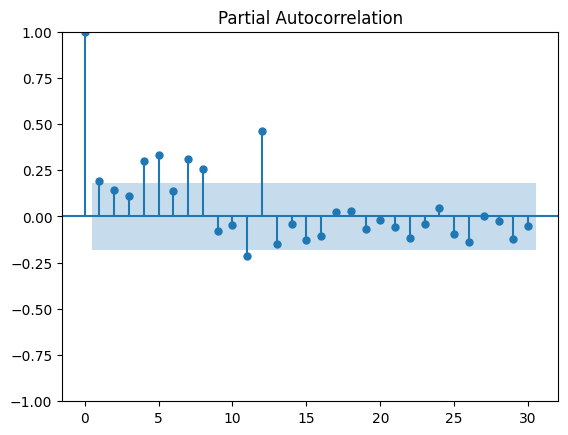

In [8]:
plot_acf(data, lags=30)
plot_pacf(data, lags=30)

In [9]:

d = range(0, 1)
p = q = range(1, 6)
pdq = list(itertools.product(p, d, q))

param_best = None
aic_best = sys.float_info.max

seasonal_order = (1, 0, 1, 12)  # 季节性部分：季节 AR 阶数为 1，差分阶数为 0，季节 MA 阶数为 1，季节周期为 12 (假设数据是按月季节性的)
for param in pdq:
	try:
		model_arima = SARIMAX(series, order=param, seasonal_order=seasonal_order)  # 创建 SARIMA 模型对象
		model_arima_fit = model_arima.fit()
		aic = model_arima_fit.aic
		if aic < aic_best:
			aic_best = aic
			param_best = param
	except:
		continue

print(f'Best param: {param_best}, AIC: {aic_best}')

C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 

Best param: (1, 0, 1), AIC: 792.1893614769208


C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
# 拟合 SARIMA 模型
order = param_best  # AR 阶数为 1，差分阶数为 0，MA 阶数为 1
print(order)
seasonal_order = (1, 0, 1, 12)  # 季节性部分：季节 AR 阶数为 1，差分阶数为 0，季节 MA 阶数为 1，季节周期为 12 (假设数据是按月季节性的)
model = SARIMAX(series, order=order, seasonal_order=seasonal_order)  # 创建 SARIMA 模型对象
results = model.fit()  # 拟合模型，估计模型参数

# 输出模型拟合结果
print(results.summary())

C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   81
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -391.095
Date:                            Sun, 28 Jul 2024   AIC                            792.189
Time:                                    16:44:46   BIC                            804.162
Sample:                                01-31-2014   HQIC                           796.993
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9938      0.004    222.354      0.000       0.985       1.003
ma.L1         -0.8589      0.032   

In [11]:
series

2014-01-31    336.216
2014-02-28     91.704
2014-03-31     68.180
2014-04-30     94.976
2014-05-31     97.472
               ...   
2020-05-31     46.560
2020-06-30     49.184
2020-07-31     96.156
2020-08-31     34.788
2020-09-30     59.816
Freq: M, Length: 81, dtype: float64

In [14]:
# 预测未来的值
forecast_start = series.index[-12] + pd.DateOffset(months=1)  # 预测起始日期为最后一个观测值的下一天
forecast_end = forecast_start + pd.DateOffset(months=24)  # 预测结束日期为起始日期后的 10 天
forecast = results.predict(start=forecast_start, end=forecast_end)  # 获取未来的预测值

# 打印预测结果
print(forecast)

2019-11-30     49.592736
2019-12-31      3.329392
2020-01-31    126.618277
2020-02-29     29.190629
2020-03-31     52.703085
2020-04-30     57.272083
2020-05-31     59.560457
2020-06-30     57.983136
2020-07-31     62.594085
2020-08-31     91.233674
2020-09-30     53.602076
2020-10-31     25.137687
2020-11-30     38.218197
2020-12-31     66.628241
2021-01-31    134.022073
2021-02-28     57.198414
2021-03-31     87.778363
2021-04-30     50.209751
2021-05-31     50.965471
2021-06-30     53.288437
2021-07-31     96.353016
2021-08-31     33.210089
2021-09-30     63.006893
2021-10-31     36.238892
2021-11-30     45.761520
Freq: M, Name: predicted_mean, dtype: float64


In [15]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

20:11:44 - cmdstanpy - INFO - Chain [1] start processing
20:11:44 - cmdstanpy - INFO - Chain [1] done processing


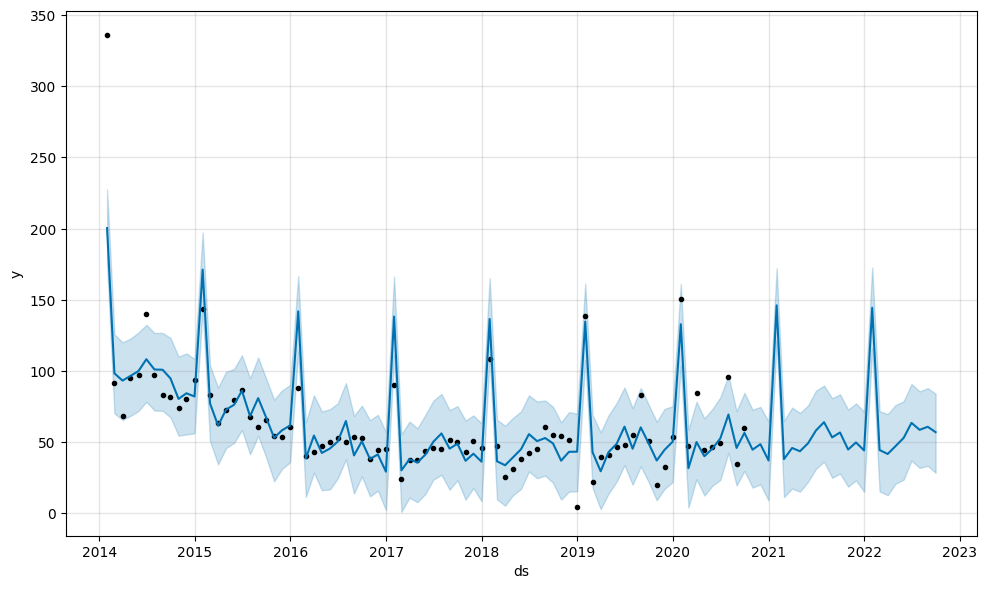

In [16]:
df = pd.DataFrame({'ds': series.index, 'y': series.values})
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)
model.plot(forecast)
plt.show()

In [17]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').loc['2019-12':]

,yhat,yhat_lower,yhat_upper
ds,,,
2019-12-31,50.392493,22.062686,75.321743
2020-01-31,132.871698,103.754589,161.290431
2020-02-29,31.716280,4.068725,58.766180
2020-03-31,50.151554,24.069567,78.425908
2020-04-30,40.168845,12.554744,66.735726
2020-05-31,45.591451,19.559419,73.399309
2020-06-30,52.743723,23.543985,81.587332
2020-07-31,69.462934,42.588801,96.866907
2020-08-31,46.006882,19.618089,71.766460
